# A Hybrid Particle Swarm Optimization for feature subset selection by integrating a novel Local Search strategy (HPSO-LS)

***BY: MohammadBagher SharifMoghaddam - 9811016***  
*Jan 1, 2023*

## Imports

In [1]:
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')

## DATA

**Dataset Description**

In [2]:
with open("./sonar/sonar.names") as f:
    print(f.read())

NAME: Sonar, Mines vs. Rocks

SUMMARY: This is the data set used by Gorman and Sejnowski in their study
of the classification of sonar signals using a neural network [1].  The
task is to train a network to discriminate between sonar signals bounced
off a metal cylinder and those bounced off a roughly cylindrical rock.

SOURCE: The data set was contributed to the benchmark collection by Terry
Sejnowski, now at the Salk Institute and the University of California at
San Deigo.  The data set was developed in collaboration with R. Paul
Gorman of Allied-Signal Aerospace Technology Center.

MAINTAINER: Scott E. Fahlman

PROBLEM DESCRIPTION:

The file "sonar.mines" contains 111 patterns obtained by bouncing sonar
signals off a metal cylinder at various angles and under various
conditions.  The file "sonar.rocks" contains 97 patterns obtained from
rocks under similar conditions.  The transmitted sonar signal is a
frequency-modulated chirp, rising in frequency.  The data set contains
signals obt

In [3]:
df = pd.read_csv("./sonar/sonar.all-data",header=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


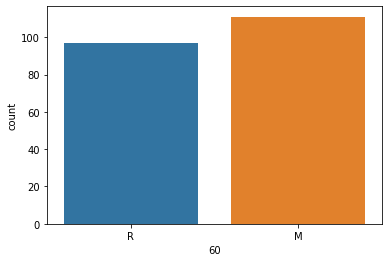

In [4]:
sns.countplot(x=df[60]);

**Defining X values and Y values**

In [5]:
X = df.drop(60, axis=1)
y = df[60]
X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078


**Train|Test Split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

**Scaling Data**

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Parameters
(Based on the article)

In [8]:
max_iter = 50
particles_num = 20
c1 = 2
c2 = 2
V_max = 4
V_min = -4
alpha = 0.65

seed = 454
features = X.columns
features_num = len(features)
salient_features = None
similar_features = []
dissimilar_features = []

## Functions 

#### Determining the number of features
- The `saliet features` is randomly selected in the range [x, M] where M = ε . f and x generally is set to 3.
- `lsf` is the probability value of determining `sf` as an initial number of features
$$
l_{sf} = \frac{f - sf}{\sum_{i=1}^{l = f-sf}(f-i)}
$$

In [9]:
def sf_determiner():
    # seed
    np.random.seed(seed)
    random.seed(seed)
        
    # define M and interval of choosing sf
    # based on article epsilon is in range of [0.15, 0.7]
    epsilon = (np.random.randint(15,70))/100
    M = int(epsilon * features_num)
    # if M is less than x in [x,M]
    M = 4 if M <= 3 else M
    
    # the probability value of determining salient features as an initial number of features : l_sf
    l_sf = []
    
    for feature in range(1,features_num):
        # nominator
        l = features_num - feature
        
        # denominator
        sums = 0
        for i in range(l):
            sums += features_num - i 
            
        l_sf.append(round(l / sums, 3))
    
    salient_features = random.choices([i for i in range(3,M)], weights= l_sf[3:M], k=1)[0]
    return salient_features    

In [10]:
salient_features = sf_determiner()
salient_features

8

#### Grouping of the features
- In this step, the features are divided into similar and dissimilar groups by Pearson correlation coefficient using equation

$$
corr_i = \frac{\sum_{j=1}^{f}|c_{ij}|}{f - 1 } \space if \space  \space i ≠ j
$$

- divide the original feature set into two equal groups.
- sorts all of the features in ascending order according to their correlation values. Those in the first half of the features have the lowest correlation values and they are put into the dissimilar group,while the rest of the fea-tures have higher correlation values and they are included in the second group called the similar group

In [11]:
def dividing_features():
    corrs = []
    # find each column correlation 
    for i in range(1,features_num):
        # Pearson Correlation Coefficient
        corr_i = X.corrwith(X[i])
        # if i = j
        corr_i[i] = 0
        
        corrs.append( (round((sum(abs(i) for i in corr_i) / (features_num - 1) ),3), i))
        corrs.sort()
    
    # dividing into Similar and Dissimilar
    # first half => Dissmilar
    dissimilar_features = corrs[:len(corrs)//2]
    # seconf half => Similar
    similar_features = corrs[len(corrs)//2:]
    
    return dissimilar_features, similar_features

In [12]:
dissimilar_features, similar_features = dividing_features()

In [13]:
print(dissimilar_features)

[(0.173, 11), (0.184, 5), (0.184, 52), (0.185, 59), (0.186, 56), (0.187, 6), (0.198, 9), (0.2, 55), (0.201, 8), (0.202, 49), (0.202, 50), (0.202, 51), (0.208, 4), (0.21, 53), (0.211, 10), (0.212, 23), (0.215, 36), (0.216, 27), (0.217, 22), (0.222, 7), (0.223, 12), (0.223, 54), (0.224, 24), (0.224, 31), (0.225, 3), (0.225, 29), (0.225, 30), (0.227, 58), (0.228, 35)]


In [14]:
print(similar_features)

[(0.229, 28), (0.23, 48), (0.23, 57), (0.232, 46), (0.233, 21), (0.233, 43), (0.235, 2), (0.236, 34), (0.237, 20), (0.238, 25), (0.238, 33), (0.238, 39), (0.241, 32), (0.242, 26), (0.248, 47), (0.249, 42), (0.252, 38), (0.254, 37), (0.255, 19), (0.257, 1), (0.26, 41), (0.261, 16), (0.262, 17), (0.263, 18), (0.265, 45), (0.271, 40), (0.271, 44), (0.272, 13), (0.277, 15), (0.281, 14)]


#### Initializing particles

- each particle is represented by a binary vector
- The length of the vector is equal to the number of the original features
- In this type of representation if the value of a cell in the vector is set to 1, it denotes that the corresponding feature is selected and when the value is set to 0, it means that the corresponding feature is not selected
- for each particle a velocity vector is generated by using a random float number generator

In [15]:
def initializing_particles():
    # seed
    np.random.seed(seed)
    
    # random initial Velocities
    velocities = [
        [round(np.random.rand(),3) for i in range(features_num)] for i in range(particles_num)
    ]
    
    # random initial particles
    particles = []
    salient_features = sf_determiner()
    
    sample_particle = [0]*(features_num-salient_features) + [1]*salient_features
    
    for particle in range(particles_num):
        np.random.shuffle(sample_particle)
        random_particle = sample_particle.copy()
        
        particles.append(random_particle)
    
    
    return particles , velocities

In [16]:
Particles, Velocities =  initializing_particles()

In [18]:
np.array(Particles).shape

(20, 60)

In [19]:
np.array(Velocities).shape

(20, 60)

#### Updating particle positions
- In PSO, each particle changes its position according to its velocityas follows
$$ v_{id}(t+1) = v_{id}(t) + c_1 . r_{i,1} . (x^{best}_i −  x_{id}(t)) . v_i(t) + c_2 . r_{i,2} . (x^{best}_g − x_{id}(t)$$

- if the sum of accelerations causes the velocity of that dimension to exceed $V_{max}$, then the velocity of that dimension is limited to $V_{max}$

- The position of a particle is changed based on the following equations

    if $ rand < sigmoid (v_{id}(t+1)) $ then $ x_{id}(t+1) = 1$ else $x_{id}(t+1) =0 $

In [20]:
def update_particle_positions(particles, velocities, best_particles, best_global):
    # seed
    np.random.seed(seed)
    
    new_velocities = np.zeros_like(velocities)
    new_positions = np.zeros_like(particles)
    
    # Particle changes 
    for particle in range(particles_num):
        for d in range(features_num):
            new_velocities[particle][d] = velocities[particle][d] + c1 * np.random.rand() * (best_particles[particle][d] - particles[particle][d]) * velocities[particle][d] + c2 * np.random.rand() * (best_global[d] - particles[particle][d])
            
            # velocities limitation
            if new_velocities[particle][d] > V_max : 
                new_velocities[particle][d] = 4  
            if new_velocities[particle][d] < V_min : 
                new_velocities[particle][d] = -4 
            
            # Changing Particle Position 
            # sigmoid func
            sigmoid = lambda x: 1 / (1 + np.exp(-x)) 
            new_positions[particle][d] = 1 if np.random.rand() < sigmoid(new_velocities[particle][d]) else 0
            
    return new_positions, new_velocities

In [21]:
# new_positions, new_velocities = update_particle_positions(Particles, Velocities, ?, ?)

#### Local Search 
- two steps are considered, including (1) feature segmentation, and (2) particle movement
- In these steps for a given particle the “Add” and “Delete” operators are employed to improve the local search of a particle
- The `Add` operator inserts the dissimilar features into the particle and the similar features are deleted from the particle using the `Delete` operator
- **The main idea behind the local search is to select distinct features with the lowest correlation.**
- X is array of feature index numbers, each element of X is compared with those of D and then the elements of X are segmented into Xd and Xs. Specifically, Xd includes the dissimilar features that are included in D and their corresponding values in the newly generated particle, while Xs includes the similar features of X which are included in both X and S
- The numbers of similar and dissimilar features are given by calculating the values of `ns` and `nd`, respectively
- Here, `ns= alpha`  . sf and `nd=(1 − alpha).sf` where `alpha` is a user specific parameter
- The number of features should be kept constant during the improvement of a particle by adding the most dissimilar features and deleting the least dissimilar ones
- When the number of dissimilar features in the particle is smaller than `nd`, then (nd− Xd) features in (D-Xd) are added to the particle, otherwise (Xd− nd) features in Xd should be deleted from the particle

In [22]:
def local_search(particles):
    # based on article
    N_s = round(alpha * salient_features)
    N_d = round((1-alpha) * salient_features)
    
    # store t+1 particle positions
    updated_particles = []
    
    for particle in range(particles_num):
#         print('before:',particles[particle])
        # Define X_d and X_s 
        features_index = [index for index,f in enumerate(particles[particle]) if f == 1]
#         print('N_s:', N_s)
#         print('N_d:', N_d)
        X_s = []
        X_d = []
        
        # Adding features to X_s and X_d
        for i in similar_features:
            if i[1] in features_index: X_s.append(i)
        for i in dissimilar_features:
            if i[1] in features_index: X_d.append(i)
        
        # ADD and DELETE Operators
        if (N_s - len(X_s)) > 0:
            for i in range(N_s - len(X_s)):
                for j in similar_features:
                    if j not in X_s:
                        X_s.append(j)
                        break
        elif (N_s - len(X_s)) < 0:
            for i in range(abs(N_s - len(X_s))):
                for j in X_s[::-1]:
                    X_s.pop()
                    break
        if 0 < (N_d - len(X_d)):
            for i in range(N_d - len(X_d)):
                for j in dissimilar_features:
                    if j not in X_d:
                        X_d.append(j)
                        break
        elif (N_d - len(X_d)) < 0:
            for i in range(abs(N_d - len(X_d))):
                for j in X_d[::-1]:
                    X_d.pop()
                    break
        
        # Only save features
        X_s = [i[1] for i in X_s]
        X_d = [i[1] for i in X_d]
        
        # Features 
        X = X_d + X_s
        
        # Add features to particle
        particle_sample = [0]* features_num
        for feature_index in X:
            particle_sample[feature_index] = 1
        new_partcle = particle_sample.copy()
        updated_particles.append(new_partcle)
        
#         print('after:', new_partcle)
        
    return updated_particles

In [23]:
print(local_search(Particles)[0])

[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Calculating fitness
- The proposed method, employs the k-NN classifier to evaluate a candidate feature subset solution


In [24]:
def calculate_fitness(particles):
    scores = []
    for particle in particles:
        # Define KNN model with CV = 10 as article suggested
        model = KNeighborsClassifier()
        params = {'n_neighbors' : [5]}
        grid_model = GridSearchCV(model, params, cv=10)

        # Select salient features
        X_tr = pd.DataFrame(X_train)[[j for i,j in zip(particle,pd.DataFrame(X_train).columns) if i==1]] 
        X_tst = pd.DataFrame(X_test)[[j for i,j in zip(particle,pd.DataFrame(X_test).columns) if i==1]]
        
        # fit model 
        grid_model.fit(X_tr,y_train)
        # predict model
        y_pred = grid_model.predict(X_tst)
        # evaluate model 
        scores.append(round(accuracy_score(y_test,y_pred),3))
        
    return scores 

In [25]:
print(calculate_fitness(Particles))

[0.725, 0.609, 0.783, 0.681, 0.652, 0.71, 0.681, 0.696, 0.681, 0.71, 0.681, 0.681, 0.725, 0.667, 0.681, 0.681, 0.71, 0.797, 0.71, 0.696]


# The HPSO-LS Algorithm

In [26]:
max_iter = 20
particles_num = 10
c1 = 2
c2 = 2
V_max = 4
V_min = -4
alpha = 0.65

seed = 555
features = X.columns
features_num = len(features)
salient_features = None
similar_features = []
dissimilar_features = []

# finding salient features 
salient_features = sf_determiner()
print('salient features: ',salient_features, '\n')

# finding similar and dissmilar features 
dissimilar_features, similar_features = dividing_features()

# initializing 
Particles, Velocities= initializing_particles()

# finding the initial scores
scores = calculate_fitness(Particles)

# evaluate particles
best_particles = [Particles[i] for i in range(len(Particles))]

# finding best global 
best_global = Particles[scores.index(max(scores))]
best_global_score = max(scores)


for iteration in range(max_iter):
    # updating t+1 particle posistions 
    new_particles, new_velocities = update_particle_positions(Particles, Velocities, best_particles, best_global)
    
    # finding t+1 particle posistions 
    new_particles = local_search(new_particles)
    
    # evaluate the t+1 particles
    new_scores = calculate_fitness(new_particles)

    # keep better particles 
    dummy_particles = []
    for particle in range(particles_num):
        if new_scores[particle] < scores[particle]:
            dummy_particles.append(Particles[particle])
        else:
            dummy_particles.append(new_particles[particle])

        # update best_global and best_global_score
        if best_global_score < new_scores[particle] :
            best_global = new_particles[particle]
            best_global_score = new_scores[particle]

    Particles = new_particles
    Velocities = new_velocities

    best_particles = dummy_particles.copy()
    scores = new_scores.copy()
    
    # printing evaluation of particles
    print('Particles Score: ▼')
    for i, particle in enumerate(best_particles):
        print(scores[i])

    print('Best Global: ', end='')
    for i in range(features_num):
        print(best_global[i], end='')
    print('\nBest Score:', best_global_score, '\n')  
        

salient features:  6 

Particles Score: ▼
0.71
0.725
0.638
0.797
0.652
0.768
0.609
0.71
0.652
0.725
Best Global: 000000000001000000001000000000000010000000000010000000000101
Best Score: 0.797 

Particles Score: ▼
0.754
0.739
0.739
0.797
0.667
0.681
0.623
0.826
0.652
0.725
Best Global: 001000000001000000001000000000000010000000000000000000000101
Best Score: 0.826 

Particles Score: ▼
0.725
0.696
0.739
0.754
0.725
0.623
0.667
0.826
0.71
0.739
Best Global: 001000000001000000001000000000000010000000000000000000000101
Best Score: 0.826 

Particles Score: ▼
0.783
0.696
0.725
0.797
0.725
0.826
0.667
0.826
0.71
0.725
Best Global: 001000000001000000001000000000000010000000000000000000000101
Best Score: 0.826 

Particles Score: ▼
0.754
0.696
0.725
0.826
0.667
0.826
0.71
0.826
0.696
0.609
Best Global: 001000000001000000001000000000000010000000000000000000000101
Best Score: 0.826 

Particles Score: ▼
0.739
0.696
0.725
0.826
0.667
0.826
0.71
0.826
0.696
0.667
Best Global: 00100000000100000000100000

---
---

# Wine DATA

In [27]:
df = pd.read_csv("./Wine/wine.data",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [28]:
X = df.drop(0, axis=1)
y = df[0]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## HPSO-LS on Wine Dataset

In [30]:
# New Parameters 
max_iter = 50
particles_num = 20
c1 = 2
c2 = 2
V_max = 4
V_min = -4
alpha = 0.65

seed = 1345
features = X.columns
features_num = len(features)
salient_features = None
similar_features = []
dissimilar_features = []
    
    
salient_features = sf_determiner()
print('salient_features:', salient_features)

dissimilar_features, similar_features = dividing_features()

Particles, Velocities= initializing_particles()

scores = calculate_fitness(Particles)

best_particles = [Particles[i] for i in range(len(Particles))]
# best_scores = scores
best_global = Particles[scores.index(max(scores))]
best_global_score = max(scores)

for iteration in range(max_iter):
    new_particles, new_velocities = update_particle_positions(Particles, Velocities, best_particles, best_global)

    new_particles = local_search(new_particles)

    new_scores = calculate_fitness(new_particles)


    dummy_particles = []
    for particle in range(particles_num):
        if new_scores[particle] < scores[particle]:
            dummy_particles.append(Particles[particle])
        else:
            dummy_particles.append(new_particles[particle])

        # update best_global and best_global_score
        if best_global_score < new_scores[particle] :
            best_global = new_particles[particle]
            best_global_score = new_scores[particle]

    Particles = new_particles
    Velocities = new_velocities

    best_particles = dummy_particles.copy()
    scores = new_scores.copy()

#     for i, particle in enumerate(best_particles):
#         print(particle.count(1),end=' ')
#         print(scores[i])

print('Best Global: ', end='')
for i in range(features_num):
    print(best_global[i], end='')
print('\nBest Score:', best_global_score, '\n')       

salient_features: 3
Best Global: 0000000100101
Best Score: 0.949 



---
***

# Heart Dataset

In [31]:
df = pd.read_csv("./heart/heart.dat",header=None, sep= ' ')
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


``` This database contains 13 attributes (which have been extracted from
a larger set of 75)       
  


Attribute Information:
------------------------
      -- 1. age       
      -- 2. sex       
      -- 3. chest pain type  (4 values)       
      -- 4. resting blood pressure  
      -- 5. serum cholestoral in mg/dl      
      -- 6. fasting blood sugar > 120 mg/dl       
      -- 7. resting electrocardiographic results  (values 0,1,2) 
      -- 8. maximum heart rate achieved  
      -- 9. exercise induced angina    
      -- 10. oldpeak = ST depression induced by exercise relative to rest   
      -- 11. the slope of the peak exercise ST segment     
      -- 12. number of major vessels (0-3) colored by flourosopy        
      -- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect     

Attributes types
-----------------

Real: 1,4,5,8,10,12
Ordered:11,
Binary: 2,6,9
Nominal:7,3,13

Variable to be predicted
------------------------
Absence (1) or presence (2) of heart disease

Cost Matrix

	 abse  pres
absence	  0	1
presence  5	0

where the rows represent the true values and the columns the predicted.

No missing values.

270 observations
```

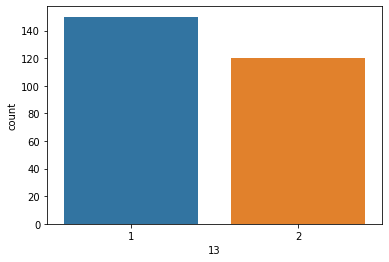

In [32]:
sns.countplot(x=df[13]);

In [33]:
X = df.drop(13, axis=1)
y = df[13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# HPSO-LS on Heart Dataset

In [34]:
# New Parameters 
max_iter = 100
particles_num = 20
c1 = 2
c2 = 2
V_max = 4
V_min = -4
alpha = 0.65

seed = 123
features = X.columns
features_num = len(features)
salient_features = None
similar_features = []
dissimilar_features = []
    
    
salient_features = sf_determiner()
print('salient_features:', salient_features)

dissimilar_features, similar_features = dividing_features()

Particles, Velocities= initializing_particles()

scores = calculate_fitness(Particles)

best_particles = [Particles[i] for i in range(len(Particles))]
# best_scores = scores
best_global = Particles[scores.index(max(scores))]
best_global_score = max(scores)

for iteration in range(max_iter):
    new_particles, new_velocities = update_particle_positions(Particles, Velocities, best_particles, best_global)

    new_particles = local_search(new_particles)

    new_scores = calculate_fitness(new_particles)


    dummy_particles = []
    for particle in range(particles_num):
        if new_scores[particle] < scores[particle]:
            dummy_particles.append(Particles[particle])
        else:
            dummy_particles.append(new_particles[particle])

        # update best_global and best_global_score
        if best_global_score < new_scores[particle] :
            best_global = new_particles[particle]
            best_global_score = new_scores[particle]

    Particles = new_particles
    Velocities = new_velocities

    best_particles = dummy_particles.copy()
    scores = new_scores.copy()

#     for i, particle in enumerate(best_particles):
#         print(particle.count(1),end=' ')
#         print(scores[i])

print('Best Global : ', end='')
for i in range(features_num):
    print(best_global[i], end='')
print('\nBest Score:', best_global_score, '\n')
print('Best Global Features :', end='')
for i in range(features_num):
    if best_global[i] == 1 : print(i, end=' ') 

salient_features: 3
Best Global : 0100000000011
Best Score: 0.822 

Best Global Features :1 11 12 

It seems that it found better features with better accuracy than article! :) 